```
This script can be used for any purpose without limitation subject to the
conditions at http://www.ccdc.cam.ac.uk/Community/Pages/Licences/v2.aspx

This permission notice and the following statement of attribution must be
included in all copies or substantial portions of this script.

2022-06-01: Made available by the Cambridge Crystallographic Data Centre.

```

# Protein-Ligand Searching in the CSD Python API

Here we illustrate how one can perform substructure searching on protein-ligand binding sites derived from the Protein Data Bank (PDB). This can help to, for example, investigate interactions between protein residues and bound small molecules or to understand the geometric preferences of small molecules bound to proteins. For further information, please see the [Descriptive Documentation](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/protein_ligand_searches.html). 

These searches are currently performed on the structure database released with [CSD-CrossMiner](https://www.ccdc.cam.ac.uk/support-and-resources/ccdcresources/CrossMiner_User_Guide_2021_3.pdf) alongside the core pharmacophore-feature database. The use of CrossMiner data means that only binding sites are stored, not full proteins, and these binding sites are defined by the presence of ligands and/or organic cofactors. Binding sites are _not_ defined by metals, water molecules and commonly-found small ions, although these entities are included (and searchable) when they fall inside a binding site.

The [Pharmacophore API](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/pharmacophore.html) allows pharmacophore-based searching of the core CrossMiner database; this will not be illustrated here.

This notebook illustrates a simple investigation the geometries of interaction between Arginine guanidino groups and ligand carboxylates. An investigation of this sort might be useful if, for example, a co-crystal structure of a lead molecule with its target showed a particular interaction to occur and a proposed modification might change the geometry of that interaction. Examining the range of geometries observed in the PDB could show whether the proposed modification might be tolerated or not.

In [ ]:
import logging
from pathlib import Path
from platform import platform
import sys
import os
from time import time

import warnings

In [ ]:
import pandas as pd

import plotly.express as px

In [ ]:
from IPython.display import HTML

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
import ccdc
from ccdc.pharmacophore import Pharmacophore
from ccdc.search import SubstructureSearch, SMARTSSubstructure, CombinedSearch

### Initialization

In [ ]:
logger = logging.getLogger(__name__)

if not logger.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter('[%(asctime)s %(levelname)-7s] %(message)s', datefmt='%y-%m-%d %H:%M:%S'))
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [ ]:
logger.info(f"""
Platform:                     {platform()}

Python exe:                   {sys.executable}
Python version:               {'.'.join(str(x) for x in sys.version_info[:3])}

CSD version:                  {ccdc.io.csd_version()}
CSD directory:                {ccdc.io.csd_directory()}
API version:                  {ccdc.__version__}

CSDHOME:                      {os.environ.get('CSDHOME', 'Not set')}
CCDC_LICENSING_CONFIGURATION: {os.environ.get('CCDC_LICENSING_CONFIGURATION', 'Not set')}
""")

#### Open the CrossMiner structure database

As the CrossMiner structure database is quite large and not of interest to all users it is not installed by default. We thus check it is present before attempting to open it for searching...

In [ ]:
db_file = Path(Pharmacophore.default_feature_database_location()).parent / 'pdb_crossminer.csdsqlx'  # Use feature-database to locate structure database

assert db_file.exists(), f"Error! The CrossMiner structure database '{db_file.resolve()}' was not found!"

Open the database...

In [ ]:
db = ccdc.io.EntryReader(str(db_file))

logger.info(f"Number of entries in CrossMiner Structure database '{db_file.resolve()}': {len(db):,d}")

### Searching for carboxylate-guanidino interactions

We will investigate the geometry of interactions between the terminal nitrogens (_i.e._ `NH1` & `NH2`) of Arginine guanidino groups and ligand carboxylate oxygens. 

To do this we will define some substructures, geometric parameters and measurements based on these. If you are familiar with the use of ConQuest for investigating geometric distributions in the CSD then the general approach will be familiar.

The substructures, parameters and measurements are illustrated below (_N.B._ this image was generated in Mercury)...

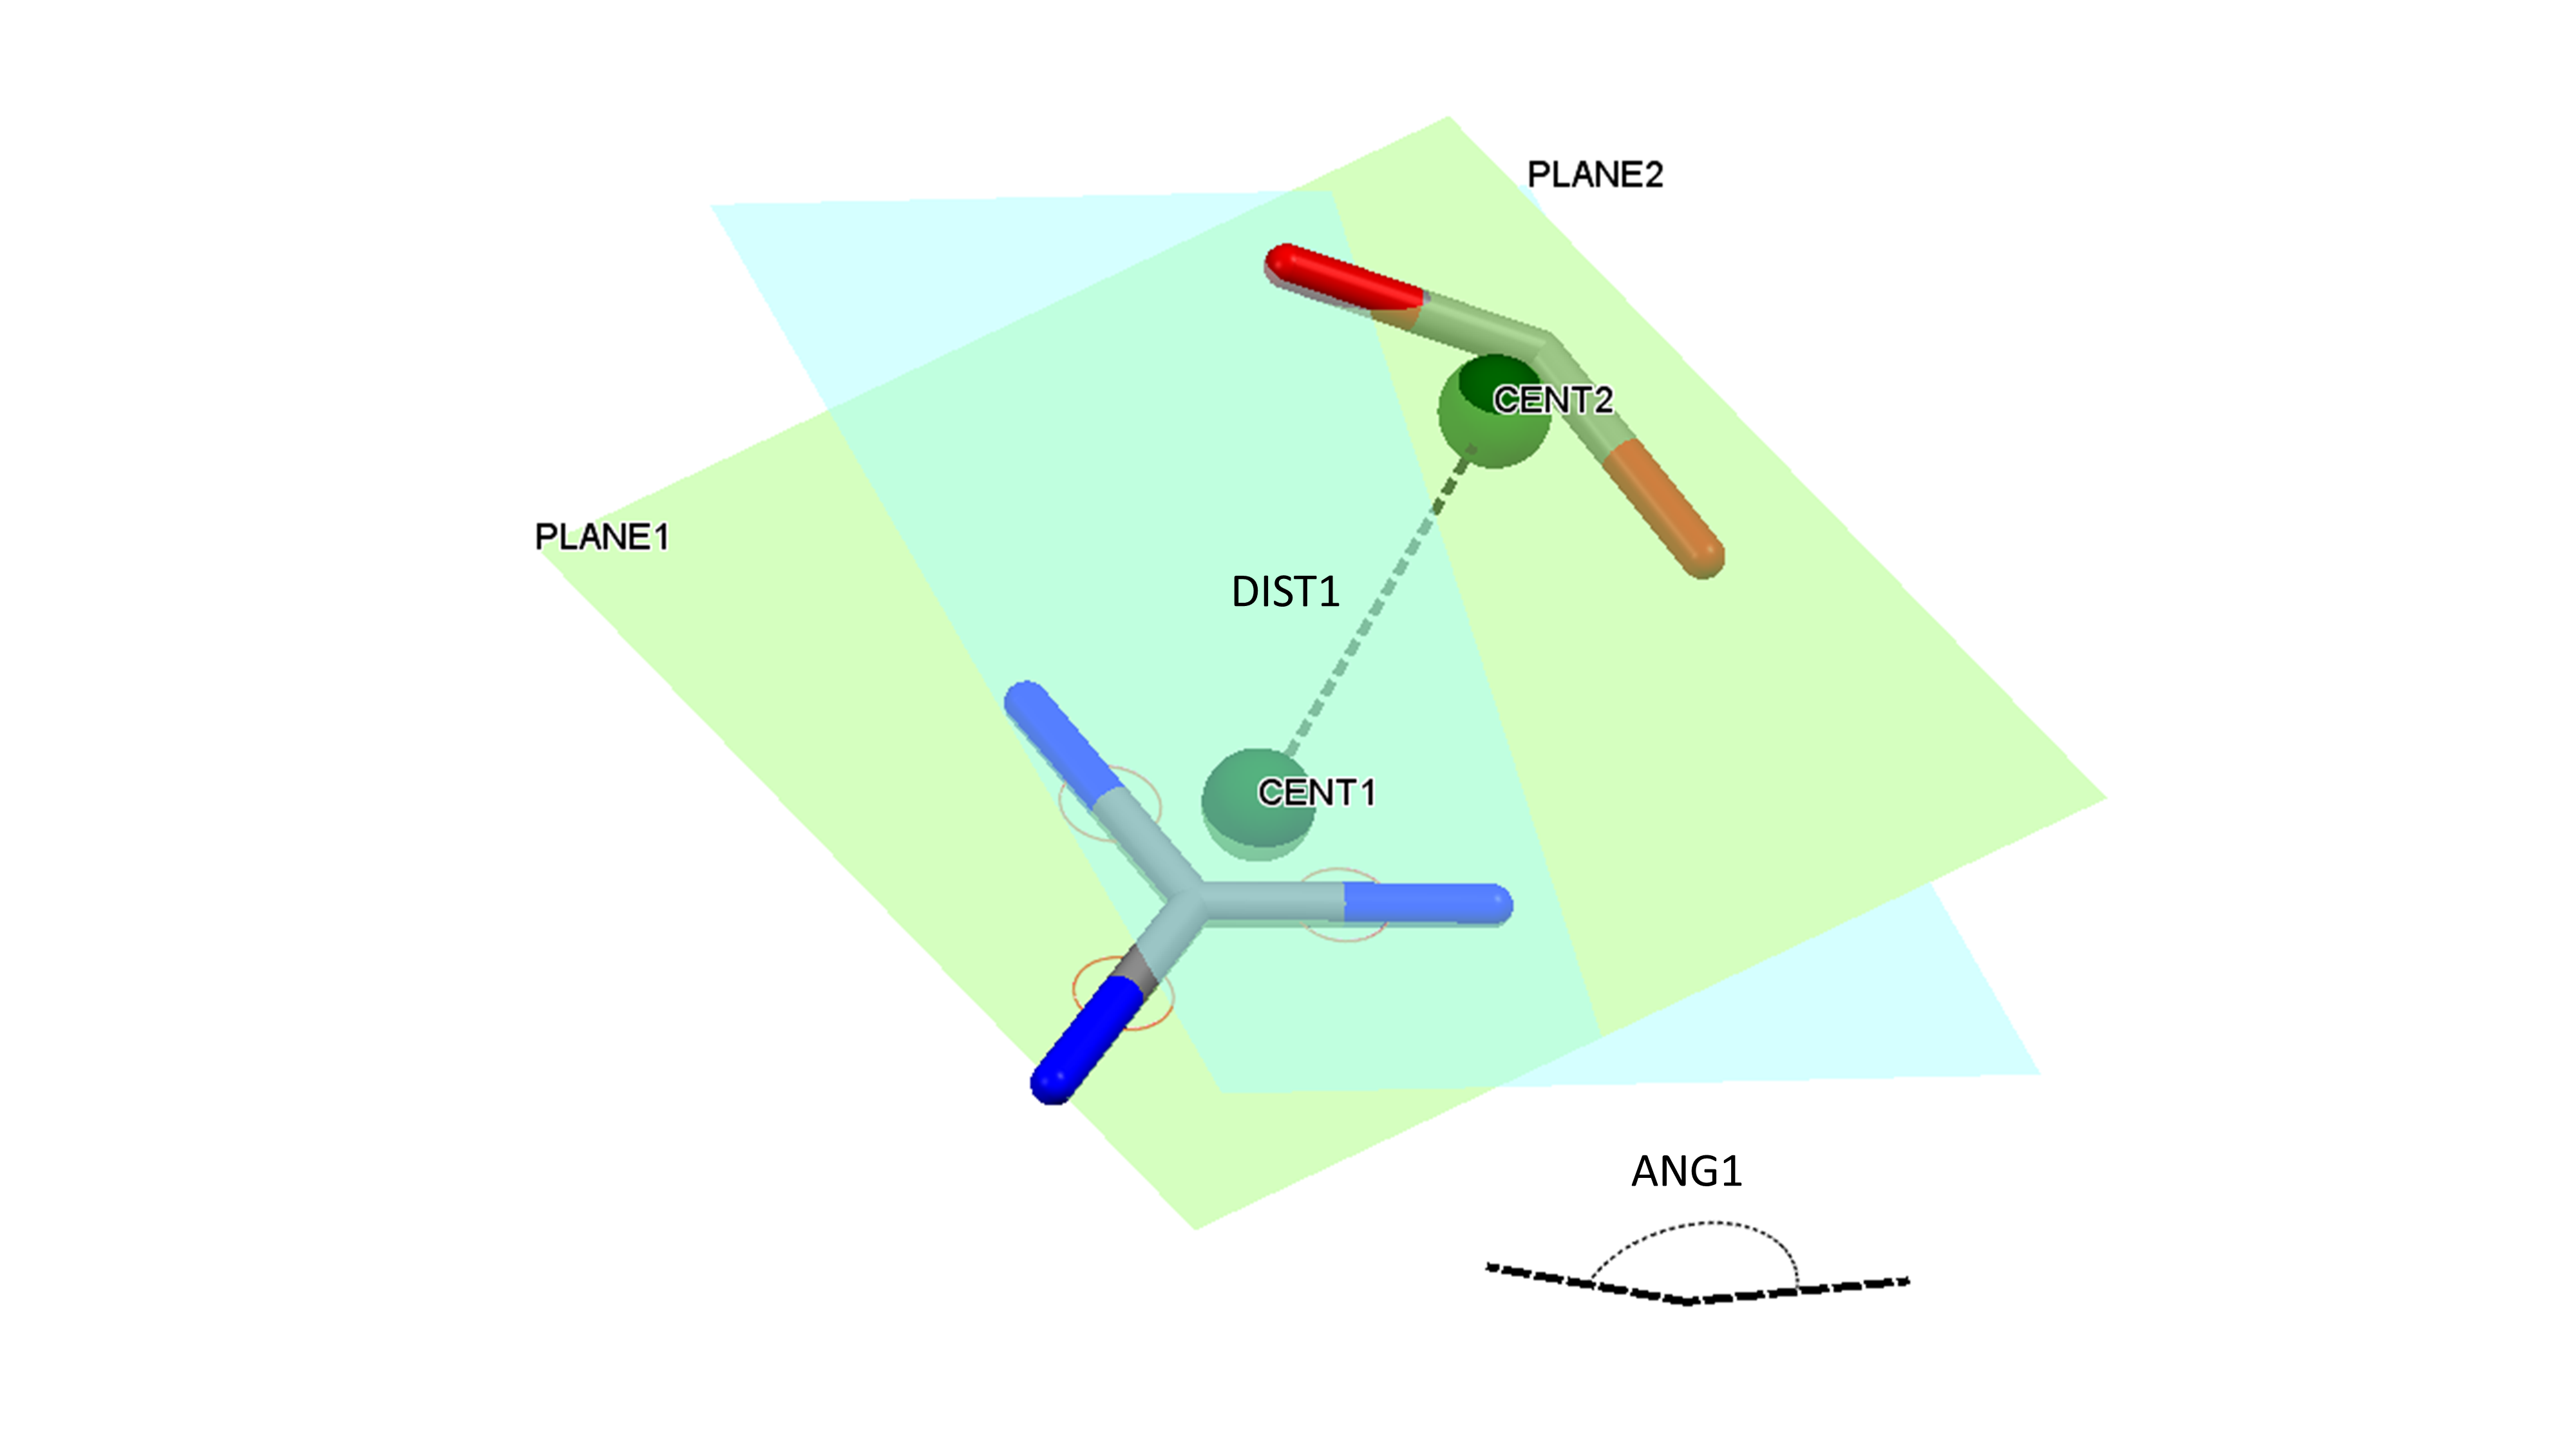

Parameter  | Type        | Definition
------     | -----       | ------
**CENT1**  | parameter   | Centroid of the two NH atoms of an arginine guanidino group
**PLANE1** | parameter   | Plane defined by the NH and CZ atoms
**CENT2**  | parameter   | Centroid of the two oxygen atoms of a ligand carboxylate
**PLANE2** | parameter   | Plane defined by all three atoms of the carboxylate 
**DIST1**  | measurement | Distance between the two centroids
**ANG1**   | measurement | Angle between the two planes

First, we will instantiate a substructure query object; this will hold the substructure-, paramater- and measurement objects...

In [ ]:
query = SubstructureSearch()

Next, we define a guanidino substructure using a SMARTS string and specify that it belongs to a protein (and thus must belong to an arginine residue).

Note the use of CSD atom-type conventions: aromatic atom and bond types are used to represent the delocalisation present in the guanidino group.

Note also the inclusion of the aliphatic carbon, corresponding to arginine `CD`, which allows us to orient the substructure and thus properly identify the terminal NH atoms. If this was ommited, the search would find interactions involving all pairs of nitrogens in the guanidino group (which might well also be of interest).

Zero-based atom indices will be used to identify atoms in the substructure; this is illustrated below, along with the corresponding PDB atom names...
```
C  n :c (:n) :n
0  1  2   3   4
CD NE CZ  NH1 NH2
```

In [ ]:
guanidino_ss = SMARTSSubstructure('Cn:c(:n):n')

for atom in guanidino_ss.atoms:
    
    atom.add_protein_atom_type_constraint('Amino')  # Type 'Amino' i.e. 'Amino acid' means protein

We add the substructure to the query, recording the identifier for later use...

In [ ]:
guanidino = query.add_substructure(guanidino_ss)

We can then define 3D paramteters using the substructure identifier and indices of atoms in the substructure.

Thus, we add the centroid defined by the `NH1` and `NH2` nitrogens...

In [ ]:
query.add_centroid('CENT1', (guanidino, 3), (guanidino, 4))

and we add the plane defined by `CZ`, `NH1` and `NH2`...

In [ ]:
query.add_plane('PLANE1', (guanidino, 2), (guanidino, 3), (guanidino, 4))

Next, we define a carboxylate group and specify that it belongs to a ligand...

In [ ]:
carboxylate_ss = SMARTSSubstructure('c~(o)~o')  # Again, note 'delocalised' CSD convention for carboxylates

for atom in carboxylate_ss.atoms:
    
    atom.add_protein_atom_type_constraint('Ligand')

In [ ]:
carboxylate = query.add_substructure(carboxylate_ss)  # Add the substructure to the query, recording the identifier for later use

In [ ]:
query.add_centroid('CENT2', (carboxylate, 1), (carboxylate, 2))  # Define centroid in terms of the carboxylate oxygens

query.add_plane('PLANE2', (carboxylate, 0), (carboxylate, 1), (carboxylate, 2))  # Define plane in terms of all three atoms in the carboxylate moiety

Finally, we add the measurements to the query.

Note that we add them as 'constraints' rather than plain 'measurements' (which are also available). This is because constraints also generate the measurements of interest, while allowing us to specify that the measurements lie in a useful range.

In [ ]:
query.add_distance_constraint('DIST1', 'CENT1', 'CENT2', (0, 3.0))

query.add_plane_angle_constraint('ANG1', 'PLANE1', 'PLANE2', (0, 30))

The search can now be run as any CSD-based [substructure search](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/substructure_searching.html#setting-up-and-running-a-substructure-search) would be.

The complete search takes ~7-8 minutes on my workstation. For speed, we could specify that we only want one hit per database entry (using `max_hits_per_structure`) and that we want cap the total number of hits (using `max_hit_structures`). To return all hits, simply omit these parameters or explicitly set them to zero.

An advantage of setting them to zero is that the query object stores the settings for a search internally. If the query object is then reused and parameters are _not_ re-set explicity (_e.g._ the search is run with `query.search(db)`), the values from the last search will be reused and results may not be what was anticipated. Obviously this would not be an issue if a new query object is set up, and this is probably the safest solution.

Another point to note if `max_hits_per_structure=1` is not used is that apparently duplicate hits can be obtained. These occur when SMARTS can match the their target functional group in two (or more) ways. In the current example, both patterns can match their targets in two ways, so each matching structure is returned four times. Given that, here, we are only interested in the identity of the hits and not in enumerating the matching atoms, this can be taken care of by simply de-duplicating the results. If a more detailed analysys is to be performed, more care will need to be taken to avoid duplication of effort.

In [ ]:
t0 = time()

hits = query.search(db)  # Returns all hits

# hits = query.search(db, max_hits_per_structure=0, max_hit_structures=0)  # Also returns all hits

# hits = query.search(db, max_hits_per_structure=1, max_hit_structures=100)  # Returns only a maximum of 100 hits

logger.info(f"Number of hits = {len(hits)}; time taken = {time()-t0:.1f} seconds.")

Make a Pandas dataframe from the hits for inspection...

In [ ]:
hits_df = pd.DataFrame(
    data=[[hit.identifier, *[hit.constraints[name] for name in ['DIST1', 'ANG1']]] for hit in hits],
    columns=['identifier', 'DIST1', 'ANG1']
).drop_duplicates()  # See note above about de-duplication

hits_df.shape

In [ ]:
hits_df

The CrossMiner identifiers appear a little complex, but just encode the identities of the source PDB structure and the ligand defining a binding site. More details are available in Section 5.2.1 'Entry Identifiers' of the CrossMiner User Guide.

Save the dataframe for later analysis, if required...

In [ ]:
# hits_df.to_pickle('hits_df.pkl')

### Plotting the results

We will use Plotly to create a scatterplot of the two measurements...

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)  # Ignore current 'distutils Version classes are deprecated' warning
    
    px.scatter(hits_df, x='DIST1', y='ANG1', hover_data=['identifier'], width=800, height=800).show()

There appears to be an outlier with an implausibly low value for the inter-centroid distance.

For convenience, to inspect this structure we will just use the PDBe visualization. To enable this, let us extract the PDB code from the CrossMiner indentifier...

In [ ]:
crossminer_id, DIST1, _ = hits_df.sort_values('DIST1').iloc[0] # Sort table of hits and unpack record with minimum DIST1

logger.info(f"CrossMiner ID = '{crossminer_id}', DIST1 = {DIST1:.2f} Å")

In [ ]:
pdb_id = crossminer_id.split('_')[0]  # Extract PDB code portion

logger.info(f"'{crossminer_id}' -> '{pdb_id}'.")

We can now create a link to the PDBe entry, which provides the full context including a 3D visualization...

In [ ]:
HTML(f'<a href="https://www.ebi.ac.uk/pdbe/entry/pdb/{pdb_id}" target="_blank">{pdb_id}</a>')